# Link Prediction in NetworKit

## Setup

In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random
from cython import *

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [3]:
def drawROC(indexName, predictions):
    X, Y = roc.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.plot([0, 1], [0, 1], ls='--')
    plt.legend(handles=[curve], loc=4)
def drawPR(indexName, predictions):
    X, Y = pr.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.legend(handles=[curve])
def drawROCs(supTitle, **args):
    predictions = args["predictions"]
    indexNames = args["indexNames"]
    plt.suptitle(supTitle, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], '#aaaaaa', ls='--')
    handles = []
    for i in range(0, len(indexNames)):
        X, Y = roc.getCurve(predictions[i])
        curve, = plt.plot(X, Y, label=indexNames[i])
        handles.append(curve)
    plt.legend(handles=handles, loc=4, fontsize=10)

## Choose graph

In [4]:
#testGraph, trainingGraph = linkprediction.readGraph("input/out.facebook-wosn-links", 0.3)
testGraph = readGraph("input/CA-CondMat_tab-sep.edgelist", Format.EdgeListTabOne)

## Create training and test set

In [5]:
trainingGraph = linkprediction.TrainingGraphSampler.byPercentage(testGraph, 0.7)
print("Train / Test =", trainingGraph.numberOfEdges(), "/", testGraph.numberOfEdges())

Train / Test = 65447 / 93497


In [35]:
edges = trainingGraph.edges()
random.shuffle(edges)
nodePairsTrain = edges[:5000] + linkprediction.MissingLinksFinder(trainingGraph).findRandomly(2, 25000)
random.shuffle(nodePairsTrain)

In [7]:
# negative instances: hop-distance 2
#while (i < 50000):
#    randNode = trainingGraph.randomNode()
#    neighbors = trainingGraph.neighbors(randNode)
#    if len(neighbors) > 0:
#        n2 = neighbors[random.randint(0, len(neighbors) - 1)]
#        neighborsN2 = trainingGraph.neighbors(n2)
#        twoHopNode = neighborsN2[random.randint(0, len(neighborsN2) - 1)]
#        if randNode != twoHopNode and not trainingGraph.hasEdge(randNode, twoHopNode):
#            nodePairsTrain[i] = (randNode, twoHopNode)

In [8]:
nodePairsTest = linkprediction.MissingLinksFinder(trainingGraph).findRandomly(2, 50000)

In [9]:
sum(linkprediction.getClasses(nodePairsTest, testGraph))

3771

In [45]:
#tmp = linkprediction.TrainingGraphSampler.byPercentage(trainingGraph, 0.7)
#supervisedTrainingNodePairs = linkprediction.MissingLinksFinder(tmp).findAll(2)
nodePairsTest = linkprediction.MissingLinksFinder(trainingGraph).findAll(2)
print("Found", len(nodePairsTest), "missing links")

Found 765646 missing links


## Create link predictor instances

In [46]:
katzIndex = linkprediction.KatzIndex(trainingGraph, 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)
uDegreeIndex = linkprediction.UDegreeIndex(trainingGraph)
vDegreeIndex = linkprediction.VDegreeIndex(trainingGraph)
algebraicDistanceIndex = linkprediction.AlgebraicDistanceIndex(trainingGraph, 5, 10)
algebraicDistanceIndex.preprocess()
neighborhoodDistanceIndex = linkprediction.NeighborhoodDistanceIndex(trainingGraph)
totalNeighborsIndex = linkprediction.TotalNeighborsIndex(trainingGraph)
neighborsMeasureIndex = linkprediction.NeighborsMeasureIndex(trainingGraph)
sameCommunityIndex = linkprediction.SameCommunityIndex(trainingGraph)
adjustedRandIndex = linkprediction.AdjustedRandIndex(trainingGraph)
resourceAllocationIndex = linkprediction.ResourceAllocationIndex(trainingGraph)

# Supervised Link Prediction

## Choose link predictors to use as feature-generators

In [47]:
linkPredictors = (commonNeighborsIndex, jaccardIndex, adamicAdarIndex, preferentialAttachmentIndex, uDegreeIndex, vDegreeIndex, algebraicDistanceIndex, neighborhoodDistanceIndex, totalNeighborsIndex, neighborsMeasureIndex, sameCommunityIndex, resourceAllocationIndex)

## Create training set with negative instances

To train a classifier there has to be a specific training set with positive (link) and negative instances (absent link) which is mostly balanced.
To create this set we randomly pick a given number of positive instances from the trainingGraph. Then we randomly pick the same number of negative instances from the trainingGraph excluding


WARNING: Right now we generate a training set from edges in the test set! Fix this!

In [36]:
# This is in case there is downsampling involved in respect to the missing links at distance 2
#tmp = linkprediction.TrainingGraphSampler.byPercentage(trainingGraph, 0.9)
#nodePairsTrain = linkprediction.MissingLinksFinder(tmp).findRandomly(2, 50000)

classesTrain = linkprediction.getClasses(nodePairsTrain, trainingGraph)
#samplesTrain = linkprediction.getSamples(nodePairsTrain, *linkPredictors)

classesTest = linkprediction.getClasses(nodePairsTest, testGraph)
samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)
print("#all:", len(nodePairsTrain), "#positives:", sum(classesTrain))

#all: 30000 #positives: 5000


In [48]:
tmp = linkprediction.TrainingGraphSampler.byPercentage(trainingGraph, 0.9)
nodePairsTrain = linkprediction.MissingLinksFinder(tmp).findAll(2)

classesTrain = linkprediction.getClasses(nodePairsTrain, trainingGraph)
#samplesTrain = linkprediction.getSamples(nodePairsTrain, *linkPredictors)

classesTest = linkprediction.getClasses(nodePairsTest, testGraph)
samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)
print("#all:", len(nodePairsTrain), "#positives:", sum(classesTrain))

#all: 691450 #positives: 4043


## Evaluation

In [49]:
roc = linkprediction.ROCMetric(testGraph)
pr = linkprediction.PrecisionRecallMetric(testGraph)

In [50]:
dtc = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5, max_features=0.5, n_jobs=-1)
#dtc = ensemble.AdaBoostClassifier()
#dtc = tree.DecisionTreeClassifier()
linkprediction.trainClassifier(nodePairsTrain, testGraph, dtc, *linkPredictors)

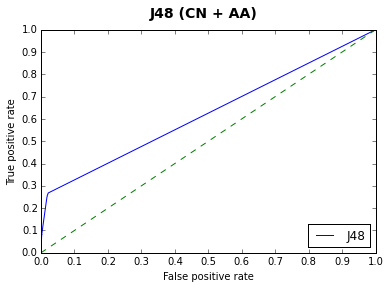

In [51]:
predictionsKNN = dtc.predict_proba(samplesTest)
isEdgePred = [x[1] for x in predictionsKNN]
#sum = 0
#for i in range(0, len(predictionsKNN)):
#    if predictionsKNN[i] == classesTest[i]:
#        sum +=1
#sum
fpr, tpr, thresholds = metrics.roc_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(fpr, tpr, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [52]:
metrics.roc_auc_score(classesTest, isEdgePred)

0.6239028019750158

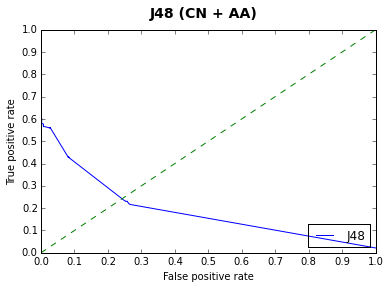

In [53]:
precision, recall, thresholds = metrics.precision_recall_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(recall, precision, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [54]:
pr.getAreaUnderCurve((recall, precision))

0.1892972343259597

In [55]:
startTime = time.time()
predictions = commonNeighborsIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.7359917163848877 seconds


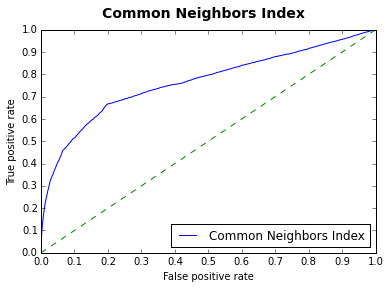

In [56]:
drawROC("Common Neighbors Index", predictions)

In [22]:
roc.getAreaUnderCurve()

0.5191041587625859

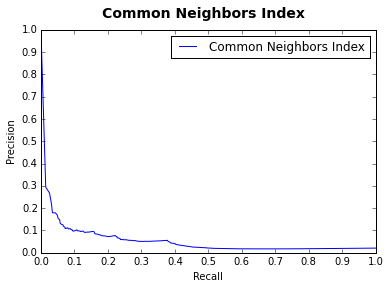

In [23]:
drawPR("Common Neighbors Index", predictions)

In [24]:
pr.getAreaUnderCurve()

0.05543890415730623

In [25]:
startTime = time.time()
predictions = jaccardIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.09138727188110352 seconds


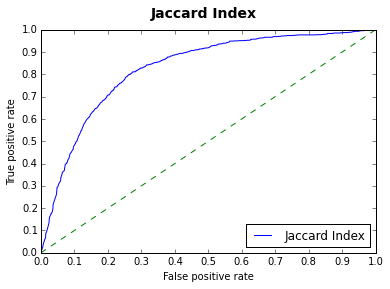

In [26]:
drawROC("Jaccard Index", predictions)

In [27]:
roc.getAreaUnderCurve()

0.8262108565591736

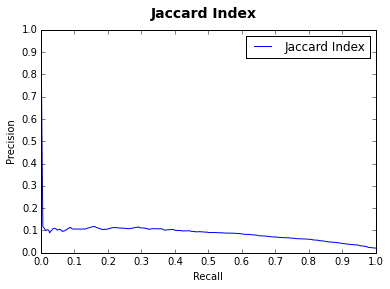

In [28]:
drawPR("Jaccard Index", predictions)

In [28]:
pr.getAreaUnderCurve()

0.15463795706249372

In [29]:
startTime = time.time()
predictions = preferentialAttachmentIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.0039136409759521484 seconds


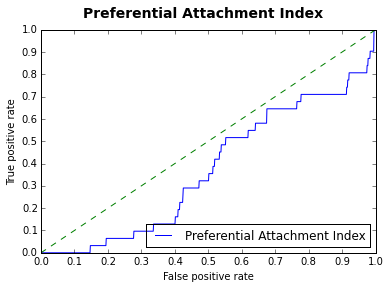

In [30]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [31]:
roc.getAreaUnderCurve()

0.3719664436232893

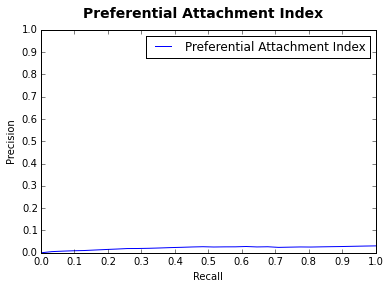

In [32]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.legend(handles=[curve])

In [33]:
pr.getAreaUnderCurve()

0.021841316663784246

In [34]:
startTime = time.time()
predictions = adamicAdarIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.0012617111206054688 seconds


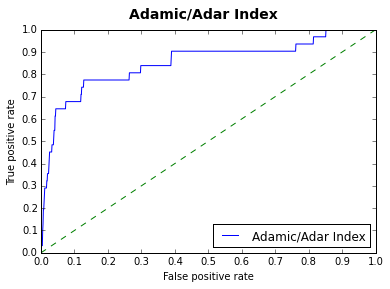

In [35]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [36]:
roc.getAreaUnderCurve()

0.8512600286294516

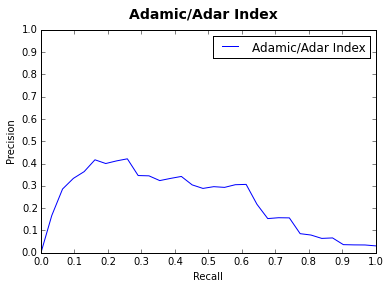

In [37]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.legend(handles=[curve])

In [38]:
pr.getAreaUnderCurve()

0.23825546653510812

In [39]:
startTime = time.time()
predictions = uDegreeIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.0005719661712646484 seconds


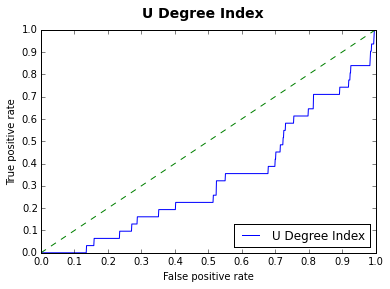

In [40]:
X, Y = roc.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [41]:
roc.getAreaUnderCurve()

0.33198508605479576

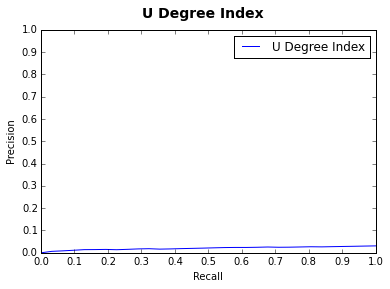

In [42]:
X, Y = pr.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.legend(handles=[curve])

In [43]:
pr.getAreaUnderCurve()

0.02043558560334799

In [44]:
startTime = time.time()
predictions = vDegreeIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.003794431686401367 seconds


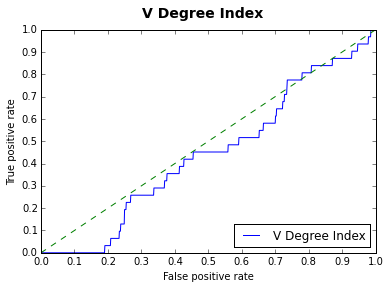

In [45]:
X, Y = roc.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [46]:
roc.getAreaUnderCurve()

0.4403442191817294

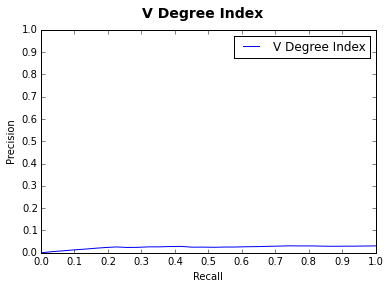

In [47]:
X, Y = pr.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.legend(handles=[curve])

In [48]:
pr.getAreaUnderCurve()

0.024820463006212757

In [49]:
startTime = time.time()
algebraicDistanceIndex.preprocess()
predictions = algebraicDistanceIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.24012541770935059 seconds


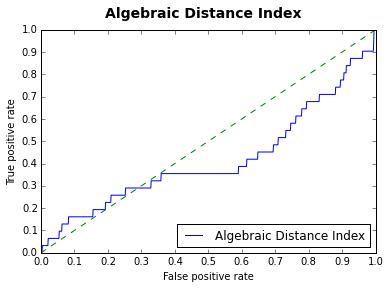

In [50]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [51]:
roc.getAreaUnderCurve()

0.4170411797995925

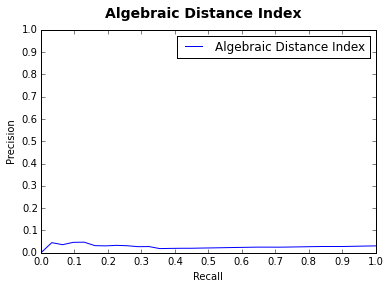

In [52]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.legend(handles=[curve])

In [53]:
pr.getAreaUnderCurve()

0.028038654195939403

In [54]:
startTime = time.time()
predictions = neighborhoodDistanceIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.00643467903137207 seconds


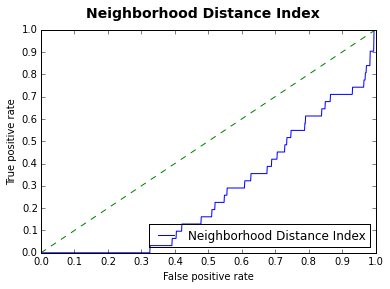

In [55]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [56]:
roc.getAreaUnderCurve()

0.2715969239988016

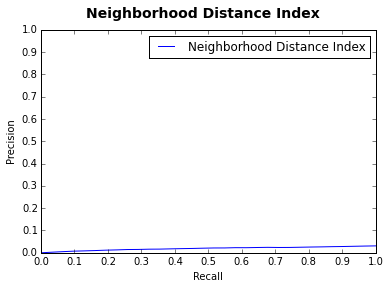

In [57]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.legend(handles=[curve])

In [58]:
pr.getAreaUnderCurve()

0.019039222819947063

In [59]:
#node = trainingGraph.randomNode()
#nodes = trainingGraph.neighbors(node)
#subGraph = graph.Subgraph().fromNodes(trainingGraph, nodes)

In [60]:
#LIST_LENGTH = len(nodes) - 1
#a = []
#color = {}
#while len(a) < LIST_LENGTH:
#    a.append(500)
#for e in nodes:
#    color[e] = len(nodes)
#a.append(2000)
#len(color)
#color[list(color)[-1]] = len(nodes) / 2
#color[list(color)[-2]] = len(nodes) / 3

In [61]:
#viztasks.drawGraph(subGraph, (7,7), False, a, None, color)

In [62]:
startTime = time.time()
predictions = katzIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

25.456860780715942 seconds


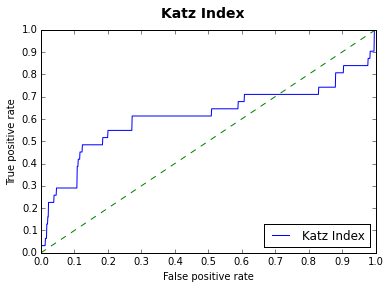

In [63]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [64]:
roc.getAreaUnderCurve()

0.614767468957024

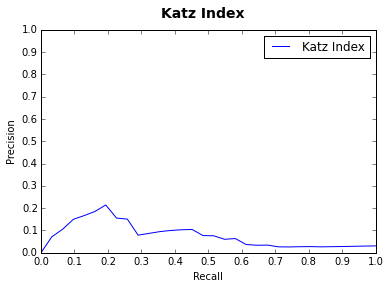

In [65]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.legend(handles=[curve])

In [66]:
pr.getAreaUnderCurve()

0.07794041836481783

In [67]:
startTime = time.time()
predictions = totalNeighborsIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.0029430389404296875 seconds


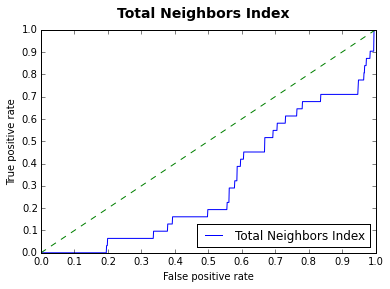

In [68]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [69]:
roc.getAreaUnderCurve()

0.3149072871933153

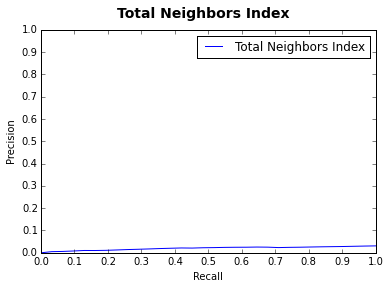

In [70]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.legend(handles=[curve])

In [71]:
pr.getAreaUnderCurve()

0.02002214502604302

In [72]:
startTime = time.time()
predictions = neighborsMeasureIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.03682899475097656 seconds


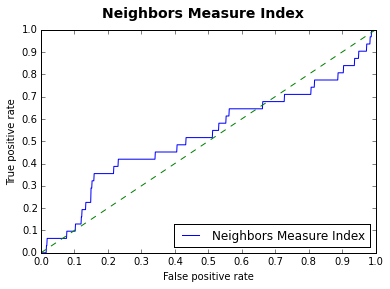

In [73]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [74]:
roc.getAreaUnderCurve()

0.5285295782149865

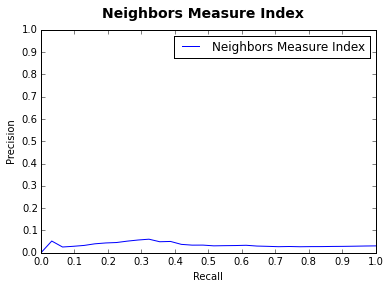

In [75]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.legend(handles=[curve])

In [76]:
pr.getAreaUnderCurve()

0.035755043695580385

In [77]:
startTime = time.time()
predictions = adjustedRandIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.005754947662353516 seconds


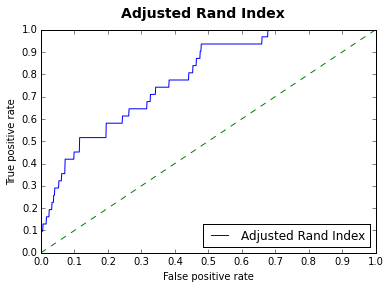

In [78]:
drawROC("Adjusted Rand Index", predictions)

In [79]:
roc.getAreaUnderCurve()

0.7852624920936109

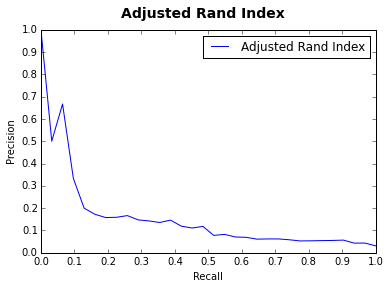

In [80]:
drawPR("Adjusted Rand Index", predictions)

In [81]:
pr.getAreaUnderCurve()

0.15154613183965543

In [112]:
startTime = time.time()
predictions = resourceAllocationIndex.runOnParallel(nodePairsTest)
print("%s seconds" % (time.time() - startTime))

0.07754254341125488 seconds


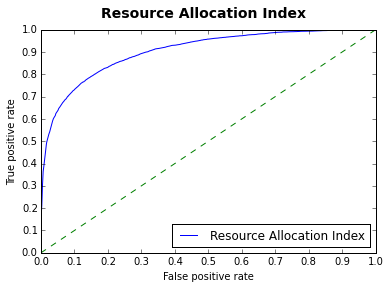

In [113]:
drawROC("Resource Allocation Index", predictions)

In [114]:
roc.getAreaUnderCurve()

0.9036854849402101

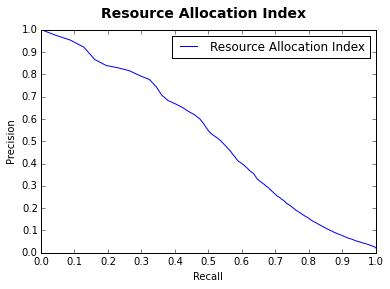

In [17]:
drawPR("Resource Allocation Index", predictions)

In [25]:
pr.getAreaUnderCurve()

0.521405639253595

In [ ]:
p1 = katzIndex.runOnParallel(nodePairsTest)
p2 = commonNeighborsIndex.runOnParallel(nodePairsTest)
p3 = jaccardIndex.runOnParallel(nodePairsTest)
p4 = preferentialAttachmentIndex.runOnParallel(nodePairsTest)
p5 = adamicAdarIndex.runOnParallel(nodePairsTest)
p6 = algebraicDistanceIndex.runOnParallel(nodePairsTest)
p7 = neighborhoodDistanceIndex.runOnParallel(nodePairsTest)
p8 = neighborsMeasureIndex.runOnParallel(nodePairsTest)
ins=["Katz", "Common Neighbors", "Jaccard", "Preferential Attachment", "Adamic/Adar", "Algebraic Distance", "Neighborhood Distance", "Neighbors-Measure"]
preds=[p1, p2, p3, p4, p5, p6, p7, p8]
drawROCs("Polblogs", indexNames=ins, predictions=preds)